# Spaceship Titanic

Filename: spaceship.ipynb \
Author: Timothy Holland \
Last updated: 20/06/2024 \
Kaggle competition: https://www.kaggle.com/competitions/spaceship-titanic/data

## Data Processing

#### Importing

In [104]:
import pandas as pd
import numpy as np

# Import the datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [105]:
# Separate the target variable
X_train = train_data.drop(['Transported'], axis=1)
y_train = train_data['Transported']
X_test = test_data

In [106]:
print("Train dataset shape:", train_df.shape)
print("Test dataset shape:", X_test.shape)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

Train dataset shape: (8693, 14)
Test dataset shape: (4277, 13)
X_train shape: (8693, 13)
y_train shape: (8693,)


#### Analysing

In [107]:
# Print the first few rows of the train dataset
print(train_data.head())

print()
# Get information about the dataset
print(train_data.info())

print()
# Check for missing values
print(train_data.isnull().sum())

print()
# Get summary statistics
print(train_data.describe())

print()
# Check the distribution of the target variable
print(y_train.value_counts())

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True  

<

#### Transforming features

In [110]:
import pandas as pd

# Function to split the Cabin feature into separate columns
def split_cabin(df):
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['Num'] = pd.to_numeric(df['Num'], errors='coerce')
    df.drop('Cabin', axis=1, inplace=True)
    return df

# Function to process PassengerId
def process_passenger_id(df):
    df[['GroupId', 'PassengerNum']] = df['PassengerId'].str.split('_', expand=True)
    df['PassengerNum'] = pd.to_numeric(df['PassengerNum'])
    df['GroupSize'] = df.groupby('GroupId')['PassengerId'].transform('count')
    df['IsSoloTraveler'] = (df['GroupSize'] == 1).astype(int)
    df.drop(['PassengerId', 'GroupId'], axis=1, inplace=True)
    return df

# Function to process Name
def process_name(df):
    df['LastName'] = df['Name'].str.split().str[-1]
    df['LastNameFrequency'] = df.groupby('LastName')['LastName'].transform('count')
    df.drop(['Name', 'LastName'], axis=1, inplace=True)
    return df

# Apply the transformations to the training dataset
X_train_transformed = X_train.copy()
X_train_transformed = split_cabin(X_train_transformed)
X_train_transformed = process_passenger_id(X_train_transformed)
X_train_transformed = process_name(X_train_transformed)

# Apply the transformations to the test dataset
X_test_transformed = X_test.copy()
X_test_transformed = split_cabin(X_test_transformed)
X_test_transformed = process_passenger_id(X_test_transformed)
X_test_transformed = process_name(X_test_transformed)

# Print the updated dataset information
print("Transformed Training Dataset:")
print(X_train_transformed.info())

print("\nTransformed Test Dataset:")
print(X_test_transformed.info())

# Print the first few rows of the transformed datasets
print("\nTransformed Training Dataset (first few rows):")
print(X_train_transformed.head())

print("\nTransformed Test Dataset (first few rows):")
print(X_test_transformed.head())

Transformed Training Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   HomePlanet         8492 non-null   object 
 1   CryoSleep          8476 non-null   object 
 2   Destination        8511 non-null   object 
 3   Age                8514 non-null   float64
 4   VIP                8490 non-null   object 
 5   RoomService        8512 non-null   float64
 6   FoodCourt          8510 non-null   float64
 7   ShoppingMall       8485 non-null   float64
 8   Spa                8510 non-null   float64
 9   VRDeck             8505 non-null   float64
 10  Deck               8494 non-null   object 
 11  Num                8494 non-null   float64
 12  Side               8494 non-null   object 
 13  PassengerNum       8693 non-null   int64  
 14  GroupSize          8693 non-null   int64  
 15  IsSoloTraveler     8693 non-null   int64  

#### Numeric correlation with target variable

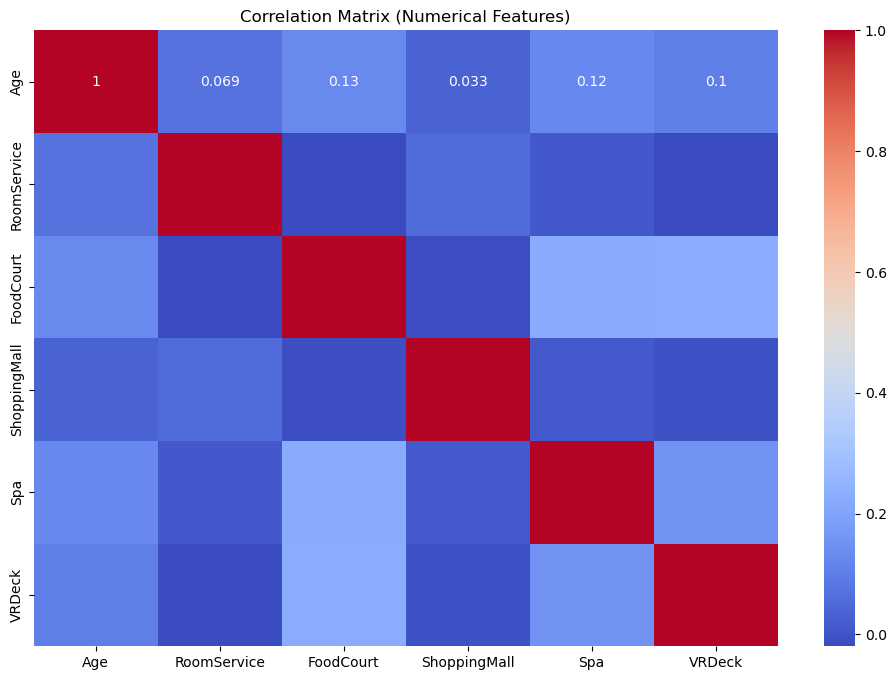

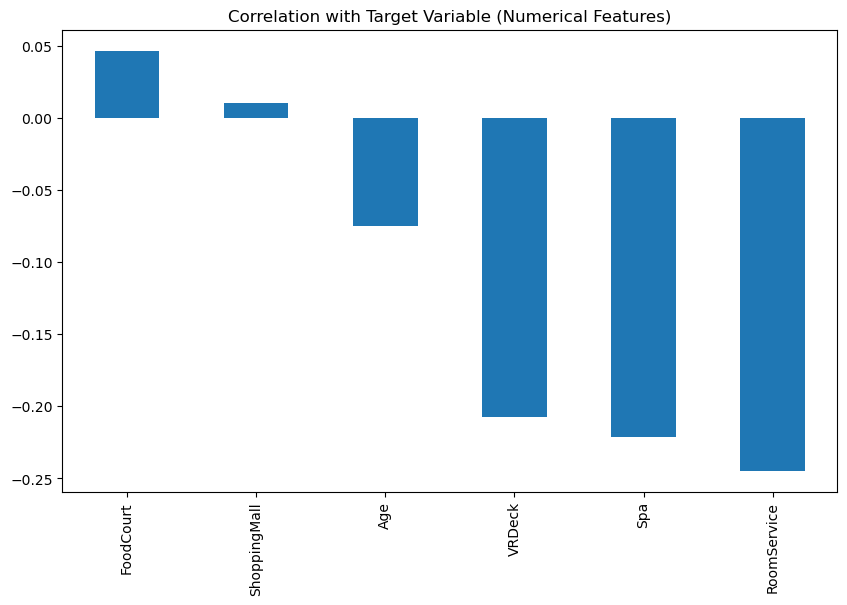

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Correlation matrix
numerical_cols = train_data.select_dtypes(include=[np.number]).columns
corr = train_data[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

# Correlation with target variable
corr_target = train_data[numerical_cols].corrwith(y_train)
corr_target = corr_target.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
corr_target.plot(kind='bar')
plt.title('Correlation with Target Variable (Numerical Features)')
plt.show()

#### Impute Missing Numeric Values

In [26]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

# Assuming X_train, y_train, and X_test are pandas DataFrames

# Function to select numeric columns
def select_numeric_columns(df):
    return df.select_dtypes(include=[np.number]).columns

# Select numeric columns
numeric_columns = select_numeric_columns(X_train)

# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=5)  # Specify the number of neighbors (you can adjust this value)

# Fit the imputer on the numeric columns of the training data
imputer.fit(X_train[numeric_columns])

# Transform the numeric columns of the training data to impute missing values
X_train_imputed = X_train.copy()
X_train_imputed[numeric_columns] = imputer.transform(X_train[numeric_columns])

# Transform the numeric columns of the test data to impute missing values
X_test_imputed = X_test.copy()
X_test_imputed[numeric_columns] = imputer.transform(X_test[numeric_columns])

# Check for missing values in the imputed datasets
print("Missing values in X_train_imputed:")
print(X_train_imputed.isnull().sum())

print("\nMissing values in X_test_imputed:")
print(X_test_imputed.isnull().sum())

# Print the shapes of the imputed datasets
print("\nImputed X_train shape:", X_train_imputed.shape)
print("y_train shape:", y_train.shape)
print("Imputed X_test shape:", X_test_imputed.shape)

# Print the list of numeric columns
print("\nNumeric columns:", list(numeric_columns))

Missing values in X_train_imputed:
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age               0
VIP             203
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
dtype: int64

Missing values in X_test_imputed:
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age               0
VIP              93
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name             94
dtype: int64

Imputed X_train shape: (8693, 12)
y_train shape: (8693,)
Imputed X_test shape: (4277, 12)

Numeric columns: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


#### Impute missing values in categorical data